## Install dependencies

In [ ]:
# ==========================================
# PART 1: INSTALLATION & SETUP
# ==========================================
import os
# Check if we need to install libs (runs only once)
try:
    import torch
    import pyfaidx
except ImportError:
    print("Installing dependencies...")
    !pip install -q transformers[torch] accelerate scikit-learn pandas pyfaidx

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from pyfaidx import Fasta

Installing dependencies...


## Download data

In [ ]:
# ==========================================
# PART 2: DATA DOWNLOAD & CLEANING (FIXED)
# ==========================================
# 1. Download ClinVar Data
if not os.path.exists("variant_summary.txt.gz"):
    print("Downloading ClinVar summary...")
    !wget -q https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz

# 2. Download Human Genome (hg38)
if not os.path.exists("hg38.fa"):
    print("Downloading Human Genome (hg38)...")
    !wget -q -O hg38.fa.gz https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
    !gunzip -f hg38.fa.gz

## Clean up data

In [ ]:
# ==============================================================================
# PART 2: DATA LOADING WITH FALLBACKS (THE FIX)
# ==============================================================================
print("\n--- LOADING WITH DATA RESCUE ---")

# Load ALL relevant columns so we can fallback if one is missing
subset_cols = [
    "Chromosome", "PositionVCF", "Start",               # Location Candidates
    "ReferenceAlleleVCF", "AlternateAlleleVCF",         # Allele Set A
    "ReferenceAllele", "AlternateAllele",               # Allele Set B (Fallback)
    "GeneSymbol", "ClinicalSignificance", "PhenotypeList",
    "Assembly", "Origin", "Type"
]

df = pd.read_csv(
    "variant_summary.txt.gz",
    sep="\t",
    compression="gzip",
    low_memory=False,
    usecols=lambda c: c in subset_cols
)

# Filter: GRCh38 + Germline + SNV
df = df[
    (df["Assembly"] == "GRCh38") &
    (df["Origin"].str.contains("germline", na=False)) &
    (df["Type"] == "single nucleotide variant")
]

# --- THE RESCUE LOGIC ---
# 1. Coalesce Position: Use PositionVCF; if missing/-1, use Start
df["final_pos"] = df["PositionVCF"]
mask_bad_vcf = (df["final_pos"].isna()) | (df["final_pos"] == -1)
df.loc[mask_bad_vcf, "final_pos"] = df.loc[mask_bad_vcf, "Start"]

# 2. Coalesce Ref/Alt: Use VCF; if 'na', use standard
df["Ref"] = df["ReferenceAlleleVCF"]
df["Alt"] = df["AlternateAlleleVCF"]

# Fix NaNs in alleles (replace 'na' string with actual NaN for coalescence)
for col in ["Ref", "Alt"]:
    df.loc[df[col].astype(str).str.lower() == "na", col] = np.nan

df["Ref"] = df["Ref"].fillna(df["ReferenceAllele"])
df["Alt"] = df["Alt"].fillna(df["AlternateAllele"])

# 3. Final Clean
df = df.dropna(subset=["Chromosome", "final_pos", "Ref", "Alt"])
df["Chromosome"] = df["Chromosome"].astype(str)
df = df[df["Ref"].str.len() == 1]
df = df[df["Alt"].str.len() == 1]

print(f"Total Usable Variants Found: {len(df):,}")


--- LOADING WITH DATA RESCUE ---
Total Usable Variants Found: 3,553,852


In [ ]:
# ==============================================================================
# PART 3: LABELING & BALANCING
# ==============================================================================
asd_keywords = r"autism|autistic|autism spectrum disorder|pervasive developmental disorder"
asd_mask = df["PhenotypeList"].str.contains(asd_keywords, case=False, na=False)
asd_genes = df[asd_mask]["GeneSymbol"].unique()
target_df = df[df["GeneSymbol"].isin(asd_genes)].copy()

def get_label(row):
    cs = str(row["ClinicalSignificance"]).lower()
    pheno = str(row["PhenotypeList"]).lower()
    # High Risk
    if "pathogenic" in cs and "benign" not in cs:
        if any(x in pheno for x in ["autism", "autistic", "pervasive"]): return 1
    # Control
    if "benign" in cs and "pathogenic" not in cs: return 0
    return None

target_df["label"] = target_df.apply(get_label, axis=1)
target_df = target_df.dropna(subset=["label"])

# Balance 1:1
pos_df = target_df[target_df["label"] == 1]
neg_df = target_df[target_df["label"] == 0]

print(f"Counts before balance: {len(pos_df)} Pathogenic, {len(neg_df)} Benign")

if len(pos_df) > 0 and len(neg_df) > 0:
    # Use ALL positives, sample negatives to match
    neg_sampled = neg_df.sample(n=len(pos_df), random_state=42)
    target_df = pd.concat([pos_df, neg_sampled]).sample(frac=1, random_state=42)
    print(f"Balanced Training Set: {len(target_df)} samples.")
else:
    print("Warning: Dataset too small to balance perfectly.")

Counts before balance: 576 Pathogenic, 78600 Benign
Balanced Training Set: 1152 samples.


In [ ]:
target_df.head(5)

,Type,GeneSymbol,ClinicalSignificance,PhenotypeList,Origin,Assembly,Chromosome,Start,ReferenceAllele,AlternateAllele,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF,final_pos,Ref,Alt,label
622234,single nucleotide variant,ADNP,Pathogenic,ADNP-related multiple congenital anomalies - i...,de novo;germline,GRCh38,20,50894197,na,na,50894197,G,A,50894197,G,A,1.0
5531677,single nucleotide variant,ITSN1,Likely benign,ITSN1-related disorder,germline,GRCh38,21,33794478,na,na,33794478,C,T,33794478,C,T,0.0
3251665,single nucleotide variant,RYR1,Likely benign,"Malignant hyperthermia, susceptibility to, 1|R...",germline,GRCh38,19,38548312,na,na,38548312,C,G,38548312,C,G,0.0
1101223,single nucleotide variant,ZSWIM6,Conflicting classifications of pathogenicity,Neurodevelopmental disorder with movement abno...,germline,GRCh38,5,61543899,na,na,61543899,C,T,61543899,C,T,1.0
1927966,single nucleotide variant,MED25,Likely benign,Charcot-Marie-Tooth disease type 2,germline,GRCh38,19,49828482,na,na,49828482,C,T,49828482,C,T,0.0


## Construct dataset

In [ ]:
# ==============================================================================
# PART 4: SEQUENCE EXTRACTION (FIXED)
# ==============================================================================
print("\n--- SEQUENCE EXTRACTION ---")
genome = Fasta('hg38.fa')
CONTEXT_LENGTH = 1000
HALF_CTX = CONTEXT_LENGTH // 2

def get_sequence_vcf(row):
    # 1. Chromosome Key
    raw_chrom = str(row['Chromosome']).replace('.0', '').strip()
    key = "chr" + raw_chrom if "chr" not in raw_chrom else raw_chrom
    if raw_chrom == "MT": key = "chrM"

    if key not in genome: return None

    try:
        # 2. Coordinates
        pos = int(row['PositionVCF']) - 1
        start = max(0, pos - HALF_CTX)
        end = pos + HALF_CTX

        # 3. Fetch Ref
        ref_seq = genome[key][start:end].seq.upper()
        if len(ref_seq) < HALF_CTX: return None

        # 4. Mutate using VCF Alleles
        alt = row['Alt'] # We renamed AlternateAlleleVCF to Alt earlier
        rel_pos = pos - start

        # Verify the Ref base in genome matches what ClinVar says (Optional but good)
        # genome_base = ref_seq[rel_pos]
        # if genome_base != row['Ref']: return None

        mutated = ref_seq[:rel_pos] + alt + ref_seq[rel_pos+1:]

        if len(mutated) != CONTEXT_LENGTH: return None
        return mutated
    except:
        return None

target_df["sequence"] = target_df.apply(get_sequence_vcf, axis=1)
print(f"Initial Training Set: {len(target_df)} sequences")
target_df_no_na = target_df.dropna(subset=["sequence"])
print(f"Final Training Set: {len(target_df_no_na)} sequences")

if len(target_df_no_na) == 0:
    raise ValueError("Extraction failed. Check genome file or data filters.")

# Split
X_train, X_val, y_train, y_val = train_test_split(
    target_df_no_na["sequence"].tolist(),
    target_df_no_na["label"].astype(int).tolist(),
    test_size=0.10,
    stratify=target_df_no_na["label"],
    random_state=0
)


--- SEQUENCE EXTRACTION ---
Initial Training Set: 1150 sequences
Final Training Set: 1150 sequences


## Train model

In [ ]:
# ==============================================================================
# PART 5: 500M MODEL FINE-TUNING (FIXED)
# ==============================================================================
import torch
import gc
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset

# 1. Clean Memory
torch.cuda.empty_cache()
gc.collect()

print("\n--- 500M MODEL SETUP ---")
model_name = "InstaDeepAI/nucleotide-transformer-v2-500m-multi-species"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

class GenomicDataset(Dataset):
    def __init__(self, seqs, lbls, tokenizer):
        self.seqs = seqs
        self.lbls = lbls
        self.tokenizer = tokenizer
    def __len__(self): return len(self.seqs)
    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.seqs[idx],
            padding="max_length",
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.lbls[idx], dtype=torch.long)
        }

def collate_fn(batch):
    return {
        'input_ids': torch.stack([x['input_ids'] for x in batch]),
        'attention_mask': torch.stack([x['attention_mask'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch])
    }

train_ds = GenomicDataset(X_train, y_train, tokenizer)
val_ds = GenomicDataset(X_val, y_val, tokenizer)

# 2. Load Model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    trust_remote_code=True,
    dtype=torch.float32
)

# --- THE FIX: FORCE ENABLE GRADIENT CHECKPOINTING ---
# This overrides the error by manually telling HF "Yes, you can do this."
model.supports_gradient_checkpointing = True
model.gradient_checkpointing_enable()
model.config.use_cache = False # Required when gradient checkpointing is on

# 3. Training Arguments
training_args = TrainingArguments(
    output_dir="./asd_500m_results",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=32,   # Small batch size
    gradient_accumulation_steps=4,   # Accumulate to simulate larger batch
    gradient_checkpointing=True,     # Now this will work!
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True,
    logging_steps=20,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn
)

print("Starting 500M Training...")
trainer.train()

# 4. Results
print("\n--- 500M RESULTS ---")
preds = trainer.predict(val_ds)
acc = (np.argmax(preds.predictions, axis=-1) == preds.label_ids).mean()
print(f"Final Accuracy: {acc:.2%}")


--- 500M MODEL SETUP ---


Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-500m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-500m-multi-species and are newly initialized: ['classifier.dense.bias', 

Starting 500M Training...


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,No log,0.676900
2,No log,0.653746
3,0.611100,0.654519
4,0.611100,0.712983
5,0.290100,0.807702
6,0.290100,0.961151
7,0.052300,1.078984
8,0.052300,1.148015
9,0.011100,1.187413
10,0.011100,1.198256


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/pyt


--- 500M RESULTS ---


Final Accuracy: 56.52%


In [ ]:
# ==============================================================================
# PART 6: EVALUATION & INFERENCE
# ==============================================================================
print("\n--- FINAL EVALUATION ---")
preds = trainer.predict(val_ds)
pred_labels = np.argmax(preds.predictions, axis=-1)
accuracy = (pred_labels == preds.label_ids).mean()

print(f"Validation Accuracy: {accuracy:.2%}")
print("Interpretation:")
print("- 50%: Random Guessing")
print("- 60%+: Model is finding genetic signal")
print("- 80%+: Strong predictive power")

# Inference Helper
def predict_sequence_risk(sequence):
    """Takes a 512bp DNA string and predicts ASD Risk"""
    model.eval()
    inputs = tokenizer(sequence, return_tensors="pt", truncation=True, max_length=512).to(model.device)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    risk_score = probs[0][1].item() # Probability of Class 1 (Pathogenic)
    return risk_score

print("\nDONE! You can now use 'predict_sequence_risk(dna_string)'")


--- FINAL EVALUATION ---


Validation Accuracy: 67.83%
Interpretation:
- 50%: Random Guessing
- 60%+: Model is finding genetic signal
- 80%+: Strong predictive power

DONE! You can now use 'predict_sequence_risk(dna_string)'


## Make figures

--- CLASSIFICATION REPORT (Text Version) ---
                precision    recall  f1-score   support

    Benign (0)       0.68      0.67      0.68        58
Pathogenic (1)       0.67      0.68      0.68        57

      accuracy                           0.68       115
     macro avg       0.68      0.68      0.68       115
  weighted avg       0.68      0.68      0.68       115


--- PROPOSAL TABLE (Copy this for your doc) ---


,precision,recall,f1-score,support
Benign,0.684211,0.672414,0.678261,58.000000
Pathogenic,0.672414,0.684211,0.678261,57.000000
accuracy,0.678261,0.678261,0.678261,0.678261
macro avg,0.678312,0.678312,0.678261,115.000000
weighted avg,0.678363,0.678261,0.678261,115.000000


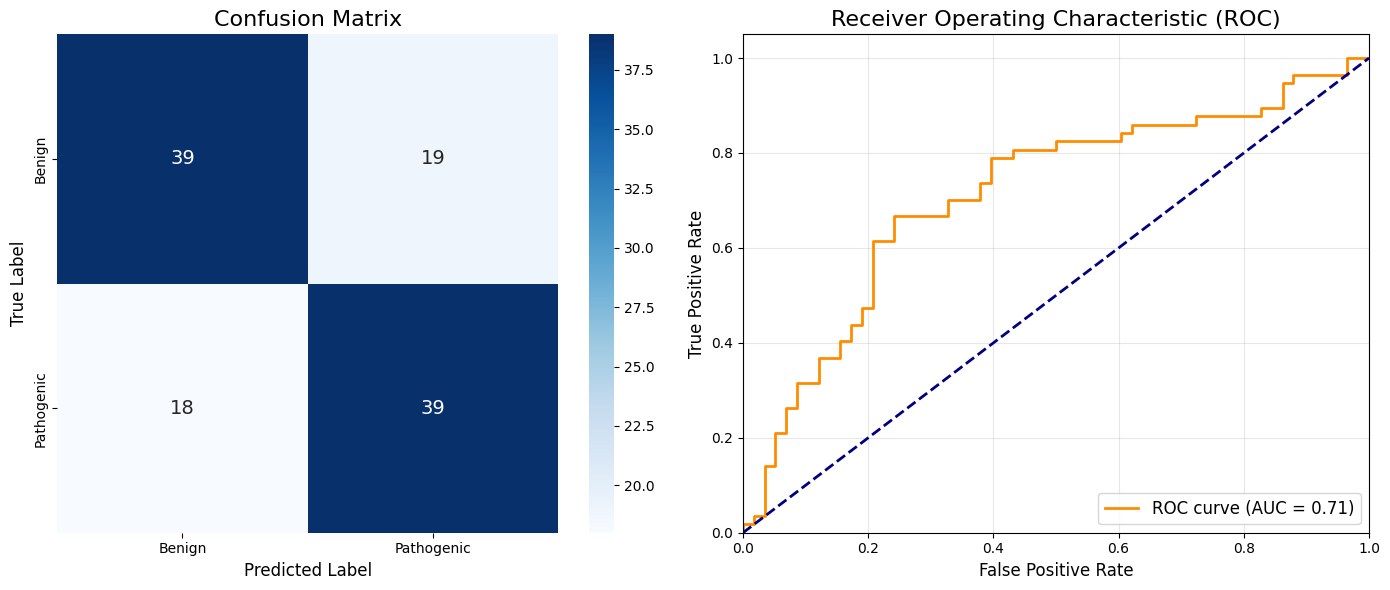


Final ROC-AUC Score: 0.71264


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import torch.nn.functional as F

# ==========================================
# 1. PREPARE PREDICTIONS
# ==========================================
# Get raw logits from the trainer
predictions = trainer.predict(val_ds)
logits = torch.tensor(predictions.predictions)
true_labels = predictions.label_ids

# Convert Logits to Probabilities (Needed for ROC)
probs = F.softmax(logits, dim=-1).numpy()
# Get the probability of Class 1 (Pathogenic)
prob_pathogenic = probs[:, 1]

# Get Hard Predictions (0 or 1) for Confusion Matrix
pred_labels = np.argmax(predictions.predictions, axis=-1)

# ==========================================
# 2. GENERATE THE TABLE (Classification Report)
# ==========================================
print("--- CLASSIFICATION REPORT (Text Version) ---")
# This looks exactly like your screenshot
print(classification_report(true_labels, pred_labels, target_names=["Benign (0)", "Pathogenic (1)"]))

# Generate a clean DataFrame for your proposal
report_dict = classification_report(true_labels, pred_labels, target_names=["Benign", "Pathogenic"], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\n--- PROPOSAL TABLE (Copy this for your doc) ---")
display(report_df.style.background_gradient(cmap='Blues', subset=['precision', 'recall', 'f1-score']))

# ==========================================
# 3. PLOT CONFUSION MATRIX & ROC CURVE
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- PLOT A: CONFUSION MATRIX ---
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Benign', 'Pathogenic'],
            yticklabels=['Benign', 'Pathogenic'],
            annot_kws={"size": 14})
axes[0].set_title("Confusion Matrix", fontsize=16)
axes[0].set_xlabel("Predicted Label", fontsize=12)
axes[0].set_ylabel("True Label", fontsize=12)

# --- PLOT B: ROC CURVE ---
fpr, tpr, thresholds = roc_curve(true_labels, prob_pathogenic)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('Receiver Operating Characteristic (ROC)', fontsize=16)
axes[1].legend(loc="lower right", fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print the specific AUC number for your records
print(f"\nFinal ROC-AUC Score: {roc_auc:.5f}")

## Global model

In [ ]:
# ==============================================================================
# PART 7: GLOBAL CLINVAR PATHOGENICITY MODEL (TRAIN ON ALL CLINVAR)
# ==============================================================================

print("\n--- BUILDING GLOBAL CLINVAR DATASET (PATHOGENIC vs BENIGN) ---")

from sklearn.model_selection import train_test_split

# We start from the same `df` that already has:
#   - GRCh38 + germline + SNV filter
#   - final_pos, Ref, Alt rescue logic

def label_global_pathogenicity(row):
    """
    General ClinVar label:
      1 = (Likely) Pathogenic
      0 = (Likely) Benign
      ignore VUS / Conflicting / Risk factor / other weird combos
    """
    cs = str(row["ClinicalSignificance"]).lower()

    # Exclude messy labels up front
    if "uncertain" in cs or "vus" in cs or "conflict" in cs or "conflicting" in cs:
        return None
    if "risk factor" in cs or "association" in cs:
        return None

    # Pathogenic side
    if ("pathogenic" in cs or "likely pathogenic" in cs) and ("benign" not in cs):
        return 1

    # Benign side
    if ("benign" in cs or "likely benign" in cs) and ("pathogenic" not in cs):
        return 0

    return None

clinvar_df = df.copy()
clinvar_df["global_label"] = clinvar_df.apply(label_global_pathogenicity, axis=1)
clinvar_df = clinvar_df.dropna(subset=["global_label"])

print(f"Total labeled ClinVar variants (global pathogenicity): {len(clinvar_df):,}")

# Balance pathogenic vs benign for training
pos_g = clinvar_df[clinvar_df["global_label"] == 1]
neg_g = clinvar_df[clinvar_df["global_label"] == 0]

print(f"Global counts before balance: {len(pos_g):,} Pathogenic, {len(neg_g):,} Benign")

if len(pos_g) == 0 or len(neg_g) == 0:
    raise ValueError("Not enough labeled variants for global model.")

# Use all of the smaller class, downsample the larger one
max_n = min(len(pos_g), len(neg_g))
pos_g = pos_g.sample(n=max_n, random_state=42)
neg_g = neg_g.sample(n=max_n, random_state=42)

global_df = pd.concat([pos_g, neg_g]).sample(frac=1, random_state=42)
print(f"Balanced global dataset: {len(global_df):,} ({max_n} P / {max_n} B)")

def get_sequence_from_final_pos(row):
    raw_chrom = str(row['Chromosome']).replace('.0', '').strip()
    key = "chr" + raw_chrom if "chr" not in raw_chrom else raw_chrom
    if raw_chrom == "MT":
        key = "chrM"

    if key not in genome:
        return None

    try:
        pos0 = int(row['final_pos']) - 1  # 0-based
        start = max(0, pos0 - HALF_CTX)
        end = pos0 + HALF_CTX

        ref_seq = genome[key][start:end].seq.upper()
        if len(ref_seq) != CONTEXT_LENGTH:
            return None

        rel_pos = pos0 - start
        alt = row['Alt']

        # Simple single-base substitution
        mutated = ref_seq[:rel_pos] + alt + ref_seq[rel_pos+1:]

        if len(mutated) != CONTEXT_LENGTH:
            return None
        return mutated
    except Exception:
        return None

print("\n--- GLOBAL: SEQUENCE EXTRACTION ---")
global_df["sequence"] = global_df.apply(get_sequence_from_final_pos, axis=1)
global_df = global_df.dropna(subset=["sequence"])

print(f"Global dataset with valid sequences: {len(global_df):,}")

Xg = global_df["sequence"].tolist()
yg = global_df["global_label"].astype(int).tolist()

Xg_train, Xg_val, yg_train, yg_val = train_test_split(
    Xg, yg,
    test_size=0.10,
    stratify=yg,
    random_state=0
)

print(f"Global train/val split: {len(Xg_train):,} train / {len(Xg_val):,} val")

# ==============================================================================
# PART 8: TRAIN SECOND MODEL (GLOBAL CLINVAR PATHOGENICITY)
# ==============================================================================

print("\n--- GLOBAL CLINVAR MODEL SETUP ---")

global_train_ds = GenomicDataset(Xg_train, yg_train, tokenizer)
global_val_ds = GenomicDataset(Xg_val, yg_val, tokenizer)

global_model_name = model_name  # "InstaDeepAI/nucleotide-transformer-v2-500m-multi-species"

global_model = AutoModelForSequenceClassification.from_pretrained(
    global_model_name,
    num_labels=2,
    trust_remote_code=True,
    dtype=torch.float32
)

# Gradient checkpointing trick again
global_model.supports_gradient_checkpointing = True
global_model.gradient_checkpointing_enable()
global_model.config.use_cache = False

global_training_args = TrainingArguments(
    output_dir="./clinvar_global_500m_results",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    num_train_epochs=5,            # you can bump this if training is stable
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True,
    logging_steps=50,
    report_to="none"
)

global_trainer = Trainer(
    model=global_model,
    args=global_training_args,
    train_dataset=global_train_ds,
    eval_dataset=global_val_ds,
    data_collator=collate_fn
)

print("\nStarting GLOBAL ClinVar Training...")
global_trainer.train()

print("\n--- GLOBAL CLINVAR VALIDATION ---")
global_preds = global_trainer.predict(global_val_ds)
global_pred_labels = np.argmax(global_preds.predictions, axis=-1)
global_acc = (global_pred_labels == global_preds.label_ids).mean()
print(f"Global ClinVar Validation Accuracy: {global_acc:.2%}")

# Optional: ROC / confusion matrix here as well if you want


--- BUILDING GLOBAL CLINVAR DATASET (PATHOGENIC vs BENIGN) ---
Total labeled ClinVar variants (global pathogenicity): 1,360,598
Global counts before balance: 156,702 Pathogenic, 1,203,896 Benign
Balanced global dataset: 313,404 (156702 P / 156702 B)

--- GLOBAL: SEQUENCE EXTRACTION ---
Global dataset with valid sequences: 313,403
Global train/val split: 282,062 train / 31,341 val

--- GLOBAL CLINVAR MODEL SETUP ---


Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-500m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-500m-multi-species and are newly initialized: ['classifier.dense.bias', 


Starting GLOBAL ClinVar Training...


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,0.173100,0.160917
2,0.104500,0.161940
3,0.026300,0.225703
4,0.004300,0.304170
5,0.000200,0.342717


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/pyt


--- GLOBAL CLINVAR VALIDATION ---


Global ClinVar Validation Accuracy: 93.88%


In [ ]:
# ==============================================================================
# PART 9: EVALUATE GLOBAL CLINVAR MODEL ON ASD VARIANTS
# ==============================================================================

print("\n--- EVALUATING GLOBAL MODEL ON ASD VARIANTS ---")

asd_seqs = target_df_no_na["sequence"].tolist()
asd_labels = target_df_no_na["label"].astype(int).tolist()

asd_ds_for_global = GenomicDataset(asd_seqs, asd_labels, tokenizer)

asd_preds_global = global_trainer.predict(asd_ds_for_global)
asd_pred_labels_global = np.argmax(asd_preds_global.predictions, axis=-1)

asd_acc_global = (asd_pred_labels_global == asd_preds_global.label_ids).mean()
print(f"Global ClinVar model accuracy on ASD set: {asd_acc_global:.2%}")

# If you also want ROC-AUC specifically for ASD:
from sklearn.metrics import roc_auc_score

asd_logits_global = asd_preds_global.predictions
asd_probs_global = F.softmax(torch.tensor(asd_logits_global), dim=-1).numpy()
asd_auc_global = roc_auc_score(asd_labels, asd_probs_global[:, 1])

print(f"Global ClinVar model ROC-AUC on ASD set: {asd_auc_global:.3f}")


--- EVALUATING GLOBAL MODEL ON ASD VARIANTS ---


Global ClinVar model accuracy on ASD set: 85.39%
Global ClinVar model ROC-AUC on ASD set: 0.938


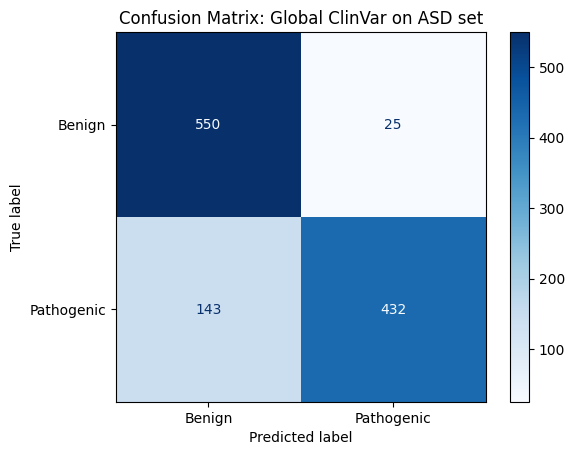

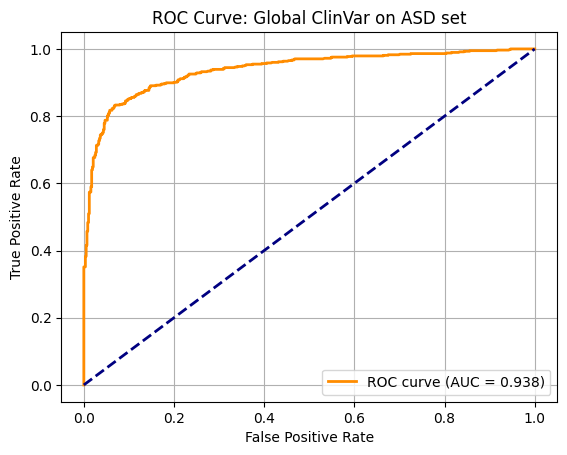

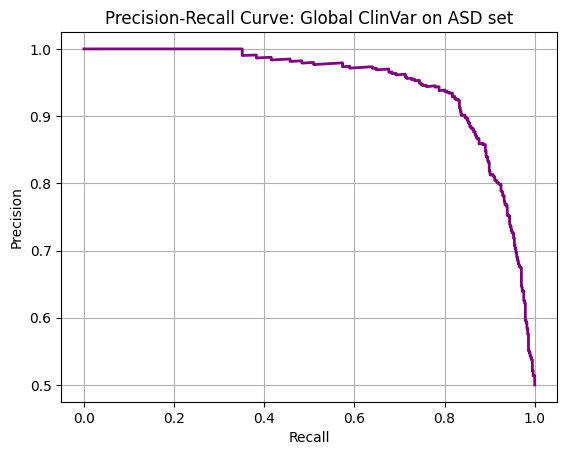

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve

# -------------------------------
# 1. Confusion Matrix on ASD set
# -------------------------------
cm = confusion_matrix(asd_labels, asd_pred_labels_global)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Pathogenic"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Global ClinVar on ASD set")
plt.show()

# -------------------------------
# 2. ROC Curve
# -------------------------------
fpr, tpr, thresholds = roc_curve(asd_labels, asd_probs_global[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Global ClinVar on ASD set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# -------------------------------
# 3. Precision-Recall Curve
# -------------------------------
precision, recall, pr_thresholds = precision_recall_curve(asd_labels, asd_probs_global[:, 1])
plt.figure()
plt.plot(recall, precision, lw=2, color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: Global ClinVar on ASD set")
plt.grid(True)
plt.show()

# -------------------------------
# 4. Optional: Accuracy over training epochs
# -------------------------------
if hasattr(global_trainer.state, "log_history"):
    # Extract validation accuracy per epoch if logged
    val_acc = []
    epochs = []
    for entry in global_trainer.state.log_history:
        if "eval_accuracy" in entry:
            val_acc.append(entry["eval_accuracy"])
            epochs.append(entry.get("epoch", len(epochs)+1))

    if val_acc:
        plt.figure()
        plt.plot(epochs, val_acc, marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Validation Accuracy")
        plt.title("Validation Accuracy over Epochs")
        plt.grid(True)
        plt.show()
